In [1]:
import itertools
import pandas as pd
import numpy as np
import os
import random 
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
"""
    This function is used to create a dataset that the model can use. The dataset will include the input data 
    (xdat) and the output data (ydat). It divides the dataset into inputs and targets.  The input data is a list of sequences of 'look_back' length, and the output data 
    is a list of single values that come 'look_ahead' after each sequence.Here we are giving 50 look back values to predict the 51st look ahead value
    
    """
def create_dataset(df, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back -look_ahead+1):
        xdat.append(df[i:i+ look_back ,0])
        ydat.append(df[i+ look_back : i + look_back + look_ahead,0])
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1,look_ahead)
    return xdat, ydat

In [3]:
 """
    This function is used to split the dataset into training and validation datasets. It also reshapes the data to the 
    required format for LSTM or GRU layers in Keras.
    """
    
def prepare_split(xdat, ydat, cutoff = 5000, timesteps = 50):
    xtrain, xvalid = xdat[:cutoff,:], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff,:], ydat[cutoff:,]
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1)
    return xtrain, ytrain, xvalid, yvalid 

In [64]:
# Main function to train the models
fitted_model_1,fitted_model_2,model = None,None,None
"""
    This function trains different models based on the model_type parameter, and makes predictions on the stock prices 
    of the provided stock_name. The function uses look_back days of data to predict the stock price look_ahead days 
    into the future. 
    """
# Define the function run_inference, which uses historical data to predict .    
def run_inference(stock_name='TITAN',look_back=50,look_ahead=1,model_type='gru',test=False,test_path=None):
    
    df = pd.read_csv('/kaggle/input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
#     else:
#         df = pd.read_csv(test_path, usecols = ['Date ', 'vwap '])
#         df.rename(columns={'Date ':'Date','vwap ':'VWAP'},inplace=True)
        
    # Set 'Date' as the index of the DataFrame.
    df['Date'] = pd.to_datetime(df['Date'])
    print(df.head())
    # Convert the 'Date' column to datetime format.
    df.set_index("Date",  inplace=True)
    #Plot the VWAP time series.
    df.VWAP.plot(xlabel = '')
   
    #plotting graph with the given data
    scaler = MinMaxScaler()
    df_a = df
    df = scaler.fit_transform(df)
    plt.xlabel('Year', fontsize=9)
    plt.ylabel('VWAP', fontsize=9)
    plt.show()
    xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)
   #for future prediction dataset, 
    if test:
        cutoff = 120
   #for training dataset
    else:
        cutoff =5000
    xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = cutoff, timesteps = look_back)
#     print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)
    test_size = .1
    
    
    
    def create_ensemble_model_1():
        # SARIMA model
        global fitted_model_1,fitted_model_2,model
        model = SARIMAX(ytrain,seasonal_order=(3, 2, 2, 2))
        fitted_model_1 = model.fit()
        forecast_1 = fitted_model_1.forecast(steps=len(xvalid))
        # ARIMA model
        model = ARIMA(ytrain, order=(2, 2, 2))
        fitted_model_2 = model.fit()
        forecast_2 = fitted_model_2.forecast(steps=len(xvalid))
        
        mean_out = np.mean(np.array([forecast_1,forecast_2]),axis=0)
        mse = mean_squared_error(yvalid, mean_out)
        print(mse)
        # LSTM model
        #Initialize a sequential model
        model=Sequential()
        ## Add the first LSTM layer with 10 units. 
# The "input_shape" argument specifies the shape of the input data, [None, 1] means any number of time steps with one feature.
# "return_sequences = True" means that the LSTM layer will return the full sequence output, which is necessary for stacking LSTM layers.
        model.add(LSTM(10,input_shape= [None,1], return_sequences = True))
    #Add the second LSTM layer with 10 units.
        model.add(LSTM(10,input_shape= [None,1]))
        model.add(Dense(look_ahead))
        ## Compile the model by specifying the loss function and the optimizer.
# The "mean_squared_error" loss function is used for regression problems, and "adam" is a common optimizer that adapts the learning rate based on how training is going.
        model.compile(loss='mean_squared_error', optimizer='adam')
        
        """"ytrain-mean_out is adjusting the target values by subtracting the mean predictions made by the ARIMA and SARIMA models 
        (stored in mean_out). This is done because the LSTM (in ensemble model 1) or GRU model(in ensemble model 2) is being used to predict the residuals (the difference between
        the actual future stock prices and the predictions made by the ARIMA and SARIMA models) instead of the actual future stock prices."""
        
       
        
        model.fit(xtrain, ytrain-mean_out, epochs=50, batch_size=64, verbose=0)
        

        # Ensemble model
#         
        lstm_pred = model.predict(xvalid)
       
   
        
        mse = mean_squared_error(yvalid, lstm_pred.reshape(-1)+mean_out)
        print(f"Mean Squared Error: {mse}")
        
        plt.figure(figsize=(12, 10))
        plt.plot(yvalid, label = 'real')
        plt.plot(lstm_pred.reshape(-1) + mean_out, label='Predicted')
        plt.xlabel('ith Prediction', fontsize=8)
        plt.ylabel('VWAP', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
    
        plt.grid(True)
        plt.legend()
        plt.show()
        
        
#         # Plotting results
#         
#         plt.plot(lstm_pred.reshape(-1)+mean_out, label = 'predicted')
#         plt.ylabel('')
#         plt.legend()
#         plt.show() 



       
    
    
    def create_ensemble_model_2():
        global fitted_model_1,fitted_model_2,model
        model = SARIMAX(ytrain,seasonal_order=(3, 2, 2, 2))
        fitted_model_1 = model.fit()
        forecast_1 = fitted_model_1.forecast(steps=len(xvalid))
        # ARIMA model
        model = ARIMA(ytrain, order=(2, 2, 2))
        fitted_model_2 = model.fit()
        forecast_2 = fitted_model_2.forecast(steps=len(xvalid))
        
        mean_out = np.mean(np.array([forecast_1,forecast_2]),axis=0)
        mse = mean_squared_error(yvalid, mean_out)
       
        model=Sequential()
        model.add(GRU(10,input_shape= [None,1], return_sequences = True))
        model.add(GRU(10,input_shape= [None,1]))
        model.add(Dense(look_ahead))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(xtrain, ytrain-mean_out, epochs=50, batch_size=64, verbose=0)
         # Ensemble model
       
        gru_pred = model.predict(xvalid)
        #ensemble_pred = np.mean([0.01*sarima_pred, 0.01*arima_pred,3*lstm_pred.reshape(len(xvalid))], axis=0)
        
        mse = mean_squared_error(yvalid, gru_pred.reshape(-1)+mean_out)
        print(f"Mean Squared Error: {mse}")
        plt.plot(yvalid, label = 'real')
        plt.plot(gru_pred.reshape(-1)+mean_out, label = 'predicted')
        plt.xlabel('ith Prediction', fontsize=9)
        plt.ylabel('VWAP', fontsize=9)
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)

        plt.grid(True)
        plt.legend()
        plt.show()
        
       
  
    
    def create_sarima_and_train():
        
        

        model = SARIMAX(ytrain,seasonal_order=(3, 2, 2, 2),

                       )
        fitted_model = model.fit()
        forecast = fitted_model.forecast(steps=len(xvalid))
        mse = mean_squared_error(yvalid, forecast)
        print(f"Mean Squared Error: {mse}")
        plt.figure(figsize=(12, 10))
        plt.plot(range(0,len(yvalid)), yvalid, label='Actual Test')
        plt.plot(range(0,len(yvalid)), forecast, label='Predicted')
        plt.ylabel('VWAP',fontsize=9)
        plt.xlabel('ith prediction',fontsize=9)
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)
        plt.grid(True)
        plt.legend()
        plt.show()
    
    def create_arima_and_train():
        x = np.concatenate((xtrain, xvalid))
        y = np.concatenate((ytrain, yvalid))
        model = ARIMA(ytrain, order=(2, 2, 2))
        fitted_model = model.fit()
        forecast = fitted_model.forecast(steps=len(xvalid))
        mse = mean_squared_error(yvalid, forecast)
        print(f"Mean Squared Error: {mse}")
        plt.figure(figsize=(12,10))
        plt.plot(range(0,len(yvalid)), yvalid, label='Actual Test')
        plt.plot(range(0,len(yvalid)), forecast, label='Predicted')
        
        
       
        plt.xlabel('ith Prediction', fontsize=9)
        plt.ylabel('VWAP', fontsize=9)
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)
    
        plt.grid(True)
        plt.legend()
        plt.show()
        
        


    def create_gru():    
    
        model=Sequential()
        model.add(GRU(10,input_shape= [None,1], return_sequences = True))
        model.add(GRU(10,input_shape= [None,1]))
        model.add(Dense(look_ahead))

        model.compile(loss='mean_squared_error',optimizer='adam')
        return model
    def create_lstm():    
    
        model=Sequential()
        model.add(LSTM(10,input_shape= [None,1], return_sequences = True))
        model.add(LSTM(10,input_shape= [None,1]))
        model.add(Dense(look_ahead))

        model.compile(loss='mean_squared_error',optimizer='adam')
        return model
    
    def train(model1):
        print(model1.summary())
        early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                               patience = 5, mode = 'min', verbose = 1,
                               restore_best_weights = True)

        model1.fit(xtrain, ytrain, validation_data=(xvalid, yvalid),  epochs = 10, batch_size =100, callbacks=[ early_stop])
        y_pred1 = model1.predict(xvalid)
       
        mse = mean_squared_error(y_pred1, yvalid)
        print(f"Mean Squared Error: {mse}")
        plt.plot(yvalid, label = 'real')
        plt.plot(y_pred1, label = 'predicted')
        plt.ylabel('VWAP',fontsize=9)
        plt.xlabel('i-th prediction',fontsize=9)
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)
        
        plt.legend()
        plt.show()
    if model_type ==  "arima":
        print("Selected Model Arima")
        create_arima_and_train()
    elif model_type ==  "sarima":
        print("Selected Model SArima")
        create_sarima_and_train()
    elif model_type ==  "lstm":
        train(create_lstm())
    elif model_type ==  "rnn":
        train(create_rnn())
    elif model_type ==  "gru":
        train(create_gru())
    elif model_type =="arima_sarima_lstm":
        create_ensemble_model_1()
    elif model_type =="arima_sarima_gru":
        create_ensemble_model_2()
    else:
        print("Please select valid model")

change name for corresponding dataset and model name 

        Date    VWAP
0 2000-01-03  154.36
1 2000-01-04  146.72
2 2000-01-05  142.95
3 2000-01-06  147.87
4 2000-01-07  148.63


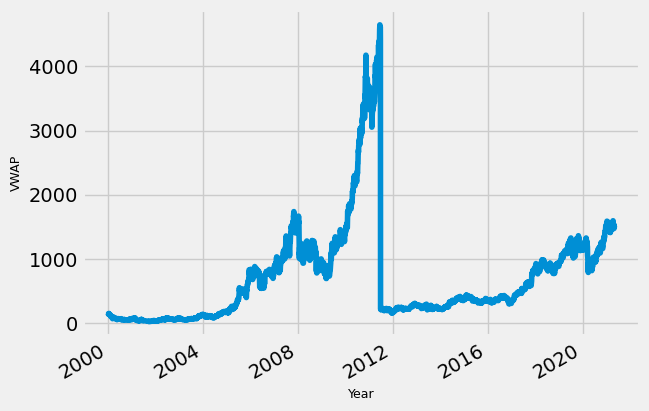

Selected Model Arima
Mean Squared Error: 0.006142425881433365


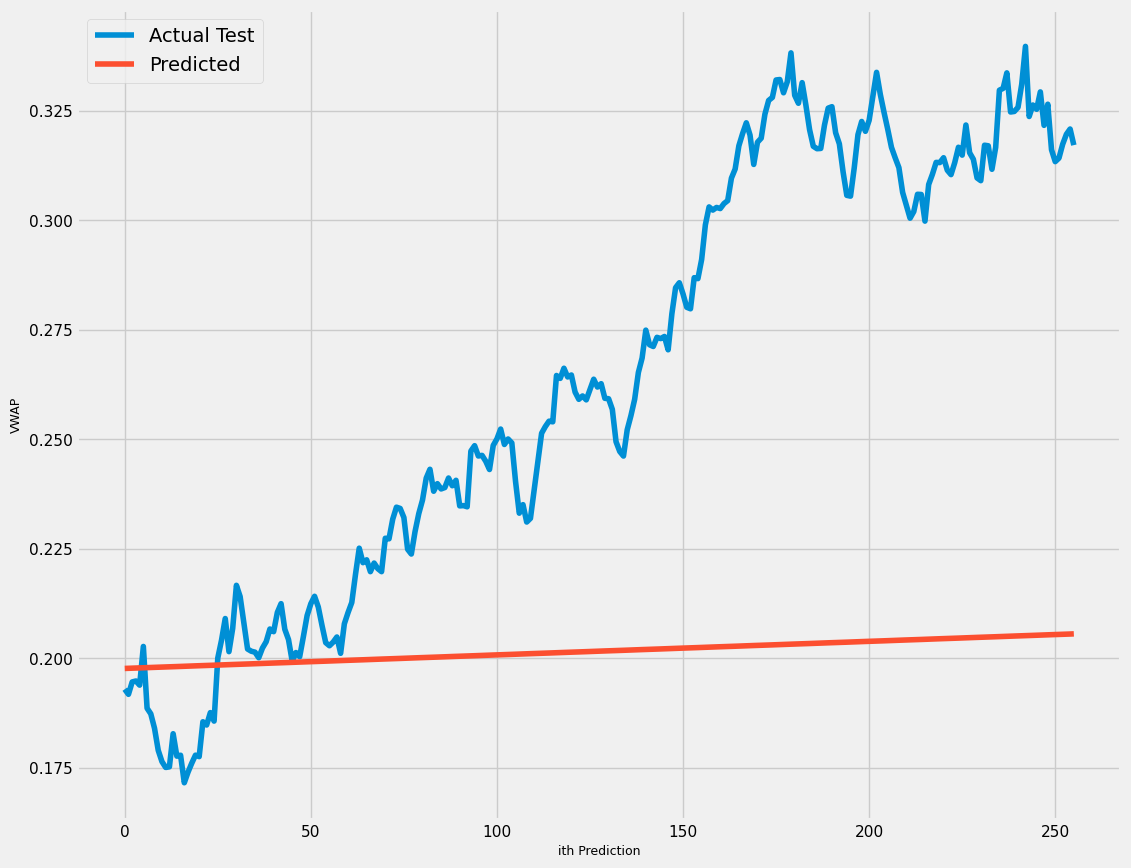

In [15]:
run_inference('TITAN',look_back = 50,look_ahead = 1,model_type="arima")

        Date    VWAP
0 2000-01-03  154.36
1 2000-01-04  146.72
2 2000-01-05  142.95
3 2000-01-06  147.87
4 2000-01-07  148.63


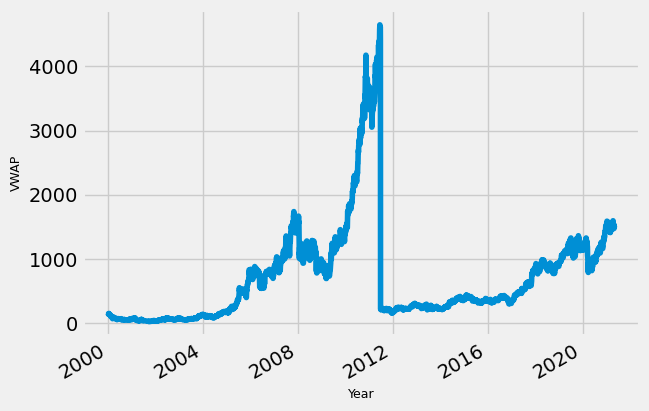

Selected Model SArima
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.44008D+00    |proj g|=  1.79250D+01


 This problem is unconstrained.



At iterate    5    f= -2.52717D+00    |proj g|=  2.48980D-01

At iterate   10    f= -2.54140D+00    |proj g|=  9.66345D+00

At iterate   15    f= -2.66433D+00    |proj g|=  2.97776D+00

At iterate   20    f= -2.72197D+00    |proj g|=  2.48352D+00

At iterate   25    f= -2.75650D+00    |proj g|=  6.93918D-01

At iterate   30    f= -2.76024D+00    |proj g|=  2.35400D-02

At iterate   35    f= -2.76420D+00    |proj g|=  7.93053D-02

At iterate   40    f= -2.76799D+00    |proj g|=  2.83480D-01

At iterate   45    f= -2.77994D+00    |proj g|=  8.91686D-01


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.78332D+00    |proj g|=  3.08235D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   3.082D-01  -2.783D+00
  F =  -2.7833158552194566     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Mean Squared Error: 0.006319451477780459


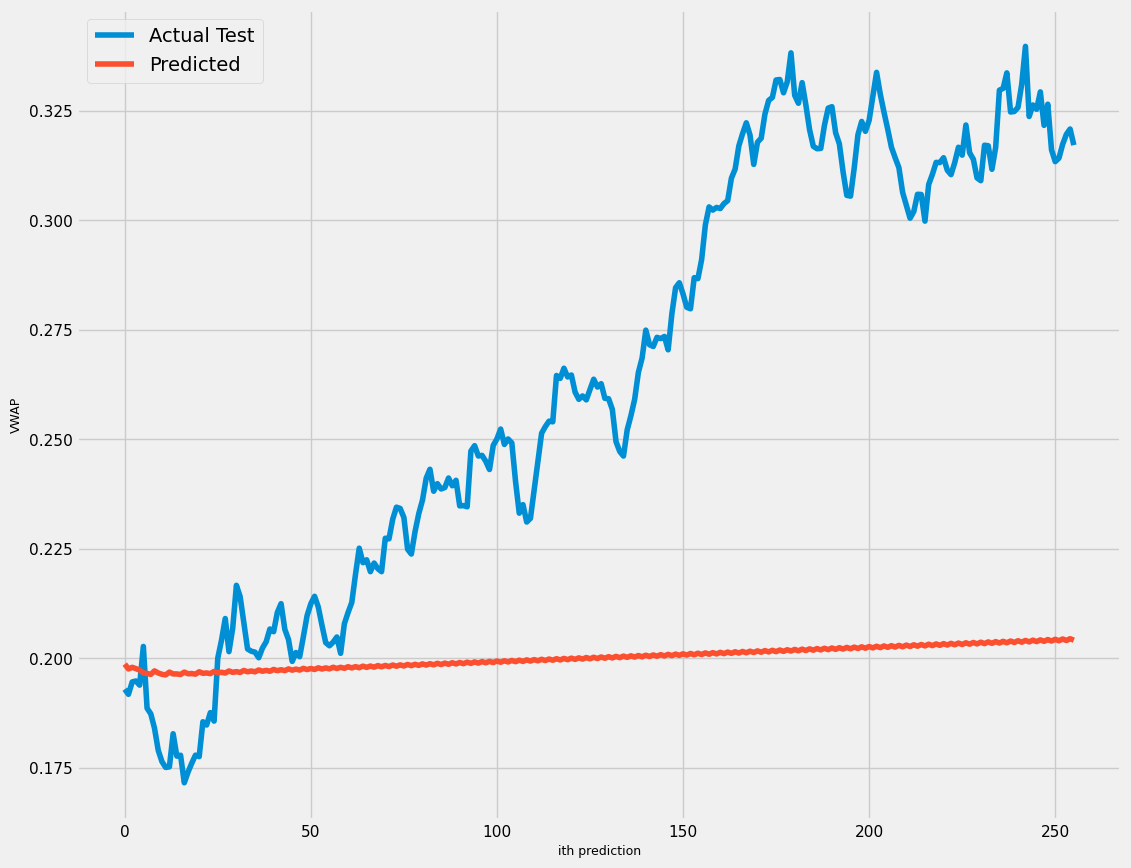

In [16]:
run_inference('TITAN',look_back = 50,look_ahead = 1,model_type="sarima")

        Date    VWAP
0 2000-01-03  154.36
1 2000-01-04  146.72
2 2000-01-05  142.95
3 2000-01-06  147.87
4 2000-01-07  148.63


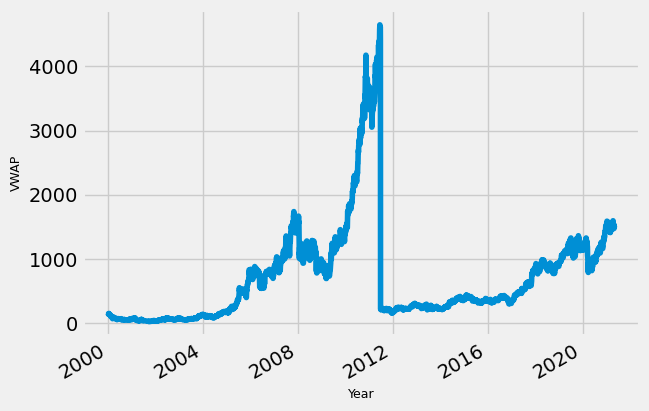

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, None, 10)          390       
                                                                 
 gru_15 (GRU)                (None, 10)                660       
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
50/50 [==============================] - 5s 41ms/step - loss: 0.0193 - val_loss: 5.4998e-04
Epoch 2/10
50/50 [==============================] - 1s 25ms/step - loss: 8.0136e-04 - val_loss: 5.4484e-05
Epoch 3/10
50/50 [==============================] - 1s 26ms/step - loss: 5.1648e-04 - val_loss: 5.88

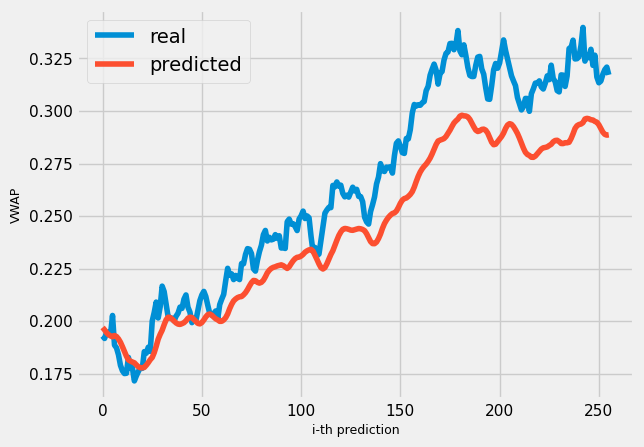

In [67]:
run_inference('TITAN',look_back = 50,look_ahead = 1,model_type="gru")

        Date    VWAP
0 2000-01-03  154.36
1 2000-01-04  146.72
2 2000-01-05  142.95
3 2000-01-06  147.87
4 2000-01-07  148.63


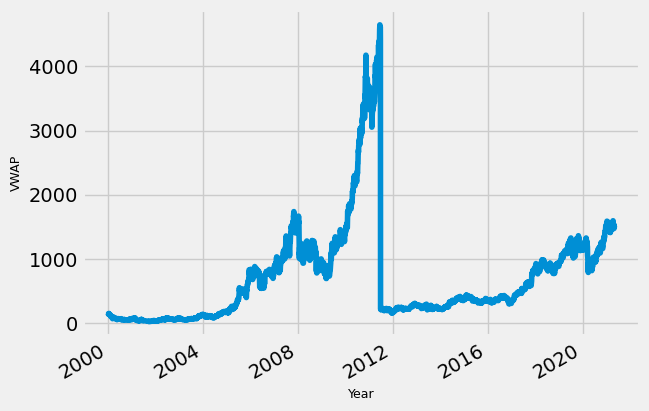

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 10)          480       
                                                                 
 lstm_5 (LSTM)               (None, 10)                840       
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
50/50 [==============================] - 7s 48ms/step - loss: 0.0061 - val_loss: 2.1030e-04
Epoch 2/10
50/50 [==============================] - 1s 29ms/step - loss: 0.0017 - val_loss: 2.0524e-04
Epoch 3/10
50/50 [==============================] - 1s 29ms/step - loss: 0.0016 - val_loss: 1.5711e-04
Ep

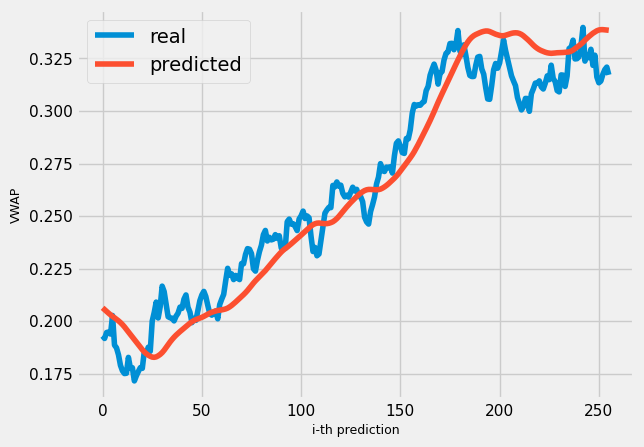

In [66]:
run_inference('TITAN',look_back = 50,look_ahead = 1,model_type="lstm")

        Date    VWAP
0 2000-01-03  154.36
1 2000-01-04  146.72
2 2000-01-05  142.95
3 2000-01-06  147.87
4 2000-01-07  148.63


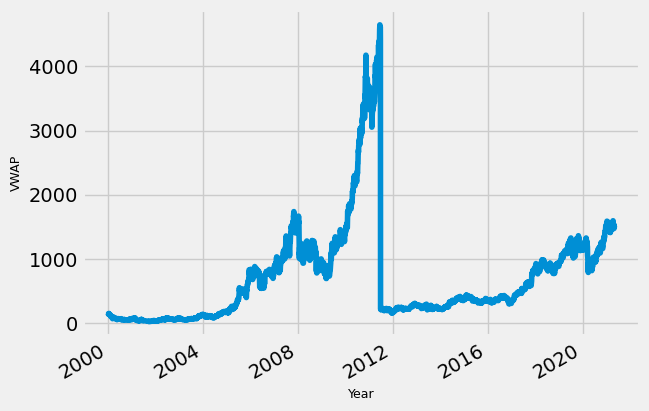

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.44008D+00    |proj g|=  1.79250D+01


 This problem is unconstrained.



At iterate    5    f= -2.52717D+00    |proj g|=  2.48980D-01

At iterate   10    f= -2.54140D+00    |proj g|=  9.66345D+00

At iterate   15    f= -2.66433D+00    |proj g|=  2.97776D+00

At iterate   20    f= -2.72197D+00    |proj g|=  2.48352D+00

At iterate   25    f= -2.75650D+00    |proj g|=  6.93918D-01

At iterate   30    f= -2.76024D+00    |proj g|=  2.35400D-02

At iterate   35    f= -2.76420D+00    |proj g|=  7.93053D-02

At iterate   40    f= -2.76799D+00    |proj g|=  2.83480D-01

At iterate   45    f= -2.77994D+00    |proj g|=  8.91686D-01


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.78332D+00    |proj g|=  3.08235D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   3.082D-01  -2.783D+00
  F =  -2.7833158552194566     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
0.00623038449508647
8/8 [==============================] - 1s 10ms/step
Mean Squared Error: 7.895307321877874e-05


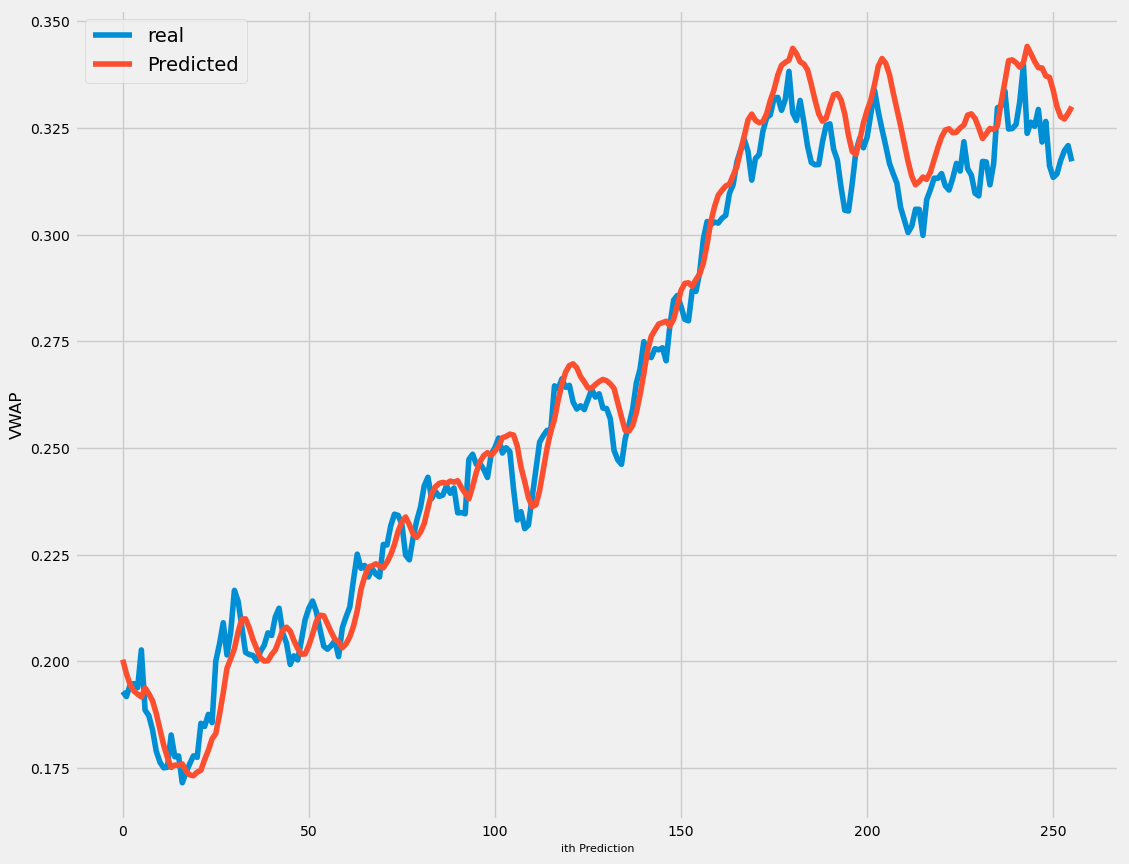

In [68]:
run_inference('TITAN',look_back = 50,look_ahead = 1,model_type="arima_sarima_lstm")

        Date    VWAP
0 2000-01-03  154.36
1 2000-01-04  146.72
2 2000-01-05  142.95
3 2000-01-06  147.87
4 2000-01-07  148.63


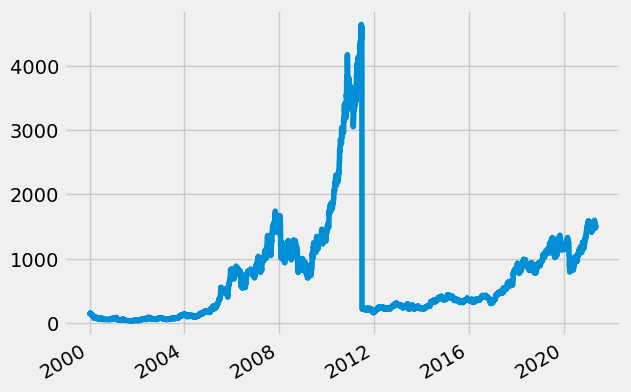

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.44008D+00    |proj g|=  1.79250D+01


 This problem is unconstrained.



At iterate    5    f= -2.52717D+00    |proj g|=  2.48980D-01

At iterate   10    f= -2.54140D+00    |proj g|=  9.66345D+00

At iterate   15    f= -2.66433D+00    |proj g|=  2.97776D+00

At iterate   20    f= -2.72197D+00    |proj g|=  2.48352D+00

At iterate   25    f= -2.75650D+00    |proj g|=  6.93918D-01

At iterate   30    f= -2.76024D+00    |proj g|=  2.35400D-02

At iterate   35    f= -2.76420D+00    |proj g|=  7.93053D-02

At iterate   40    f= -2.76799D+00    |proj g|=  2.83480D-01

At iterate   45    f= -2.77994D+00    |proj g|=  8.91686D-01

At iterate   50    f= -2.78332D+00    |proj g|=  3.08235D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8/8 [==============================] - 1s 12ms/step
Mean Squared Error: 3.5565684182484595e-05


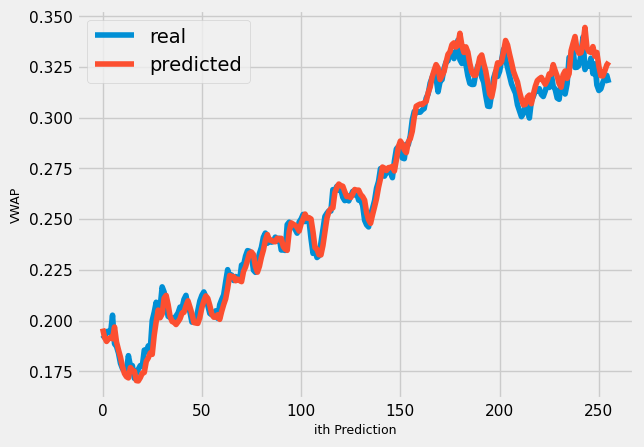

In [6]:
run_inference('TITAN',look_back = 50,look_ahead = 1,model_type="arima_sarima_gru")

        Date    VWAP
0 2000-01-03  154.36
1 2000-01-04  146.72
2 2000-01-05  142.95
3 2000-01-06  147.87
4 2000-01-07  148.63


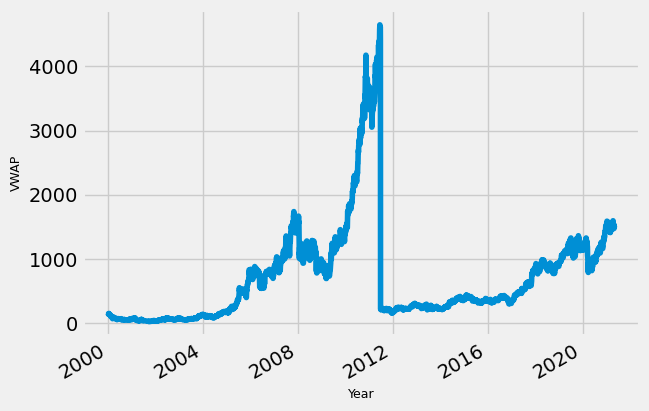

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.44008D+00    |proj g|=  1.79250D+01

At iterate    5    f= -2.52717D+00    |proj g|=  2.48980D-01

At iterate   10    f= -2.54140D+00    |proj g|=  9.66345D+00

At iterate   15    f= -2.66433D+00    |proj g|=  2.97776D+00

At iterate   20    f= -2.72197D+00    |proj g|=  2.48352D+00

At iterate   25    f= -2.75650D+00    |proj g|=  6.93918D-01

At iterate   30    f= -2.76024D+00    |proj g|=  2.35400D-02

At iterate   35    f= -2.76420D+00    |proj g|=  7.93053D-02

At iterate   40    f= -2.76799D+00    |proj g|=  2.83480D-01

At iterate   45    f= -2.77994D+00    |proj g|=  8.91686D-01


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.78332D+00    |proj g|=  3.08235D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   3.082D-01  -2.783D+00
  F =  -2.7833158552194566     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
8/8 [==============================] - 1s 9ms/step
Mean Squared Error: 4.8529071253598544e-05


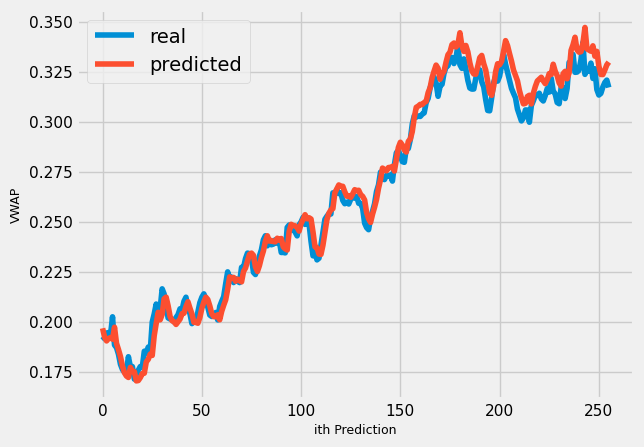

In [21]:
import ipywidgets as widgets
path = '/kaggle/input/tilltue-new/Quote-Equity-TITAN-EQ-21-06-2022-to-20-06-2023.csv'
run_inference(stock_name='TITAN',model_type="arima_sarima_gru",look_back=50,look_ahead=1)


In [24]:
path = '/kaggle/input/tilltue-new/Quote-Equity-TITAN-EQ-21-06-2022-to-20-06-2023.csv'
df = pd.read_csv(path, usecols = ['Date ', 'vwap '])
df.rename(columns={'Date ':'Date','vwap ':'VWAP'},inplace=True)
menu_options =list(df['Date'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",  inplace=True)
scaler = MinMaxScaler()
df_a = df
df = scaler.fit_transform(df)
xdat, ydat = create_dataset(df[::-1], look_back = 50, look_ahead = 1)
menu_options = menu_options[:-50]

In [25]:
selected_option = None
cur_x,cur_y  = None,None
ind = None
def handle_dropdown_change(change):
    global  selected_option,ind
    selected_option = change.new
    print(selected_option)
    menu_options_rev = menu_options[::-1]
    ind = menu_options_rev.index(selected_option)
    print(ind)
    global cur_x,cur_y
    cur_x,cur_y = xdat[ind],ydat[ind] 
from IPython.display import display
dropdown = widgets.Dropdown(options=menu_options, description='Select an option:')
dropdown.observe(handle_dropdown_change, names='value')
display(dropdown)


Dropdown(description='Select an option:', options=('6/20/2023', '6/19/2023', '6/16/2023', '6/15/2023', '6/14/2…

In [32]:
forecast_1 = fitted_model_1.forecast(steps=ind+1)[ind] 
forecast_2 = fitted_model_2.forecast(steps=ind+1)[ind]
print(f"Predicted : {scaler.inverse_transform(np.mean([forecast_1,forecast_2],axis=0)+model.predict(cur_x.reshape(1,-1,1)))} actual{scaler.inverse_transform(cur_y.reshape(-1,1))}")

1/1 [==============================] - 0s 26ms/step
Predicted : [[2896.9941]] actual[[2897.1]]


In [29]:
forecast_1 = fitted_model_1.forecast(steps=ind+2)[ind+1]
forecast_2 = fitted_model_2.forecast(steps=ind+2)[ind+1]
cur_x = np.append(cur_x,cur_y)[1:]
print(f"Predicted : {scaler.inverse_transform(np.mean([forecast_1,forecast_2],axis=0)+model.predict(cur_x.reshape(1,-1,1)))}")

1/1 [==============================] - 0s 26ms/step
Predicted : [[2960.8645]]


        Date    VWAP
0 2000-01-03  154.36
1 2000-01-04  146.72
2 2000-01-05  142.95
3 2000-01-06  147.87
4 2000-01-07  148.63


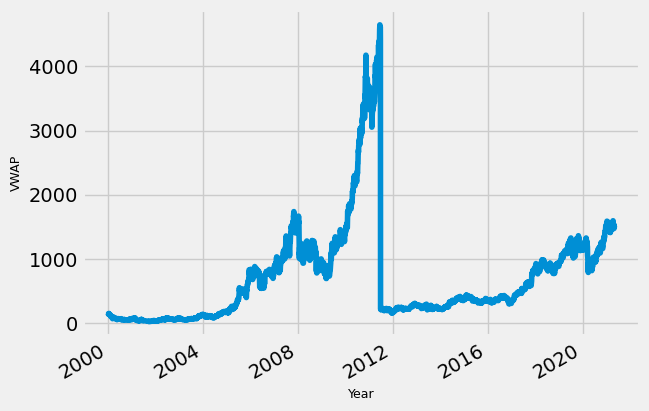

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.44008D+00    |proj g|=  1.79250D+01

At iterate    5    f= -2.52717D+00    |proj g|=  2.48980D-01

At iterate   10    f= -2.54140D+00    |proj g|=  9.66345D+00

At iterate   15    f= -2.66433D+00    |proj g|=  2.97776D+00

At iterate   20    f= -2.72197D+00    |proj g|=  2.48352D+00

At iterate   25    f= -2.75650D+00    |proj g|=  6.93918D-01

At iterate   30    f= -2.76024D+00    |proj g|=  2.35400D-02

At iterate   35    f= -2.76420D+00    |proj g|=  7.93053D-02

At iterate   40    f= -2.76799D+00    |proj g|=  2.83480D-01

At iterate   45    f= -2.77994D+00    |proj g|=  8.91686D-01


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.78332D+00    |proj g|=  3.08235D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   3.082D-01  -2.783D+00
  F =  -2.7833158552194566     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
0.00623038449508647
8/8 [==============================] - 1s 10ms/step
Mean Squared Error: 0.0001413905714802384


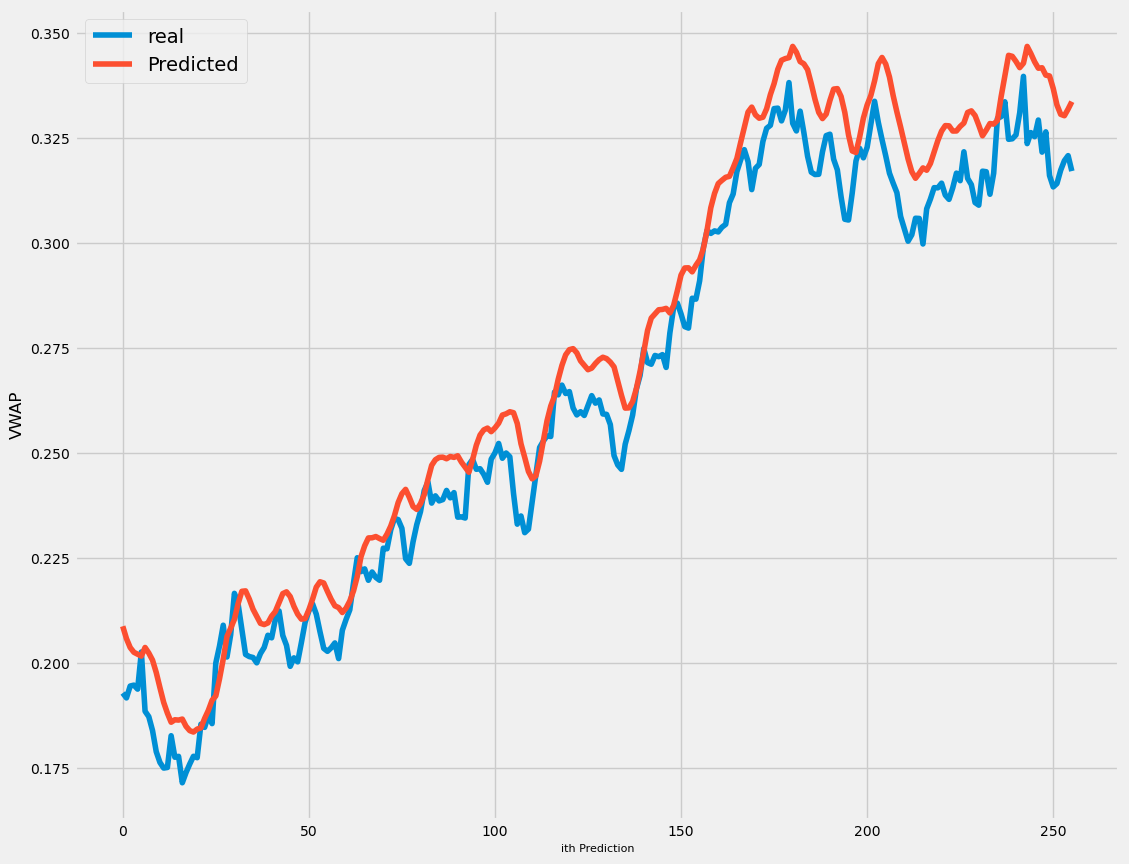

In [33]:
import ipywidgets as widgets
run_inference(stock_name='TITAN',model_type="arima_sarima_lstm")

In [36]:
df = pd.read_csv(path, usecols = ['Date ', 'vwap '])
df.rename(columns={'Date ':'Date','vwap ':'VWAP'},inplace=True)
menu_options =list(df['Date'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",  inplace=True)
scaler = MinMaxScaler()
df_a = df
df = scaler.fit_transform(df)
xdat, ydat = create_dataset(df[::-1], look_back = 50, look_ahead = 1)
menu_options = menu_options[:-50]

In [37]:
selected_option = None
cur_x,cur_y  = None,None
ind = None
def handle_dropdown_change(change):
    global  selected_option,ind
    selected_option = change.new
    print(selected_option)
    menu_options_rev = menu_options[::-1]
    ind = menu_options_rev.index(selected_option)
    print(ind)
    global cur_x,cur_y
    cur_x,cur_y = xdat[ind],ydat[ind] 
from IPython.display import display
dropdown = widgets.Dropdown(options=menu_options, description='Select an option:')
dropdown.observe(handle_dropdown_change, names='value')
display(dropdown)


Dropdown(description='Select an option:', options=('6/20/2023', '6/19/2023', '6/16/2023', '6/15/2023', '6/14/2…

In [55]:
#for current day's prediction
forecast_1 = fitted_model_1.forecast(steps=ind+1)[ind]
forecast_2 = fitted_model_2.forecast(steps=ind+1)[ind]

print(f"Predicted : {scaler.inverse_transform(np.mean([forecast_1,forecast_2],axis=0)+model.predict(cur_x.reshape(1,-1,1)))} actual{scaler.inverse_transform(cur_y.reshape(-1,1))}")

1/1 [==============================] - 0s 28ms/step
Predicted : [[2878.5103]] actual[[2897.1]]


In [57]:
#for next day's prediction
forecast_1 = fitted_model_1.forecast(steps=ind+2)[ind+1]
forecast_2 = fitted_model_2.forecast(steps=ind+2)[ind+1]
cur_x = np.append(cur_x,cur_y)[1:]
print(f"Predicted : {scaler.inverse_transform(np.mean([forecast_1,forecast_2],axis=0)+model.predict(cur_x.reshape(1,-1,1)))} ")

1/1 [==============================] - 0s 28ms/step
Predicted : [[2942.2432]] 
